# Plot output h5 data generated via ddcurves



In [1]:
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection

%matplotlib notebook

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#f = h5py.File('DATA_QC/test_beta-samples.h5','r')
#h5file = 'DATA_QC/IMOS_Density_KIM200_2013_a_beta-samples-array-all-data.h5'
datafile1 = 'DATA_QC/Crux_KP150_Phs1_Density_lowpass'
datafile2 = 'DATA_QC/Crux_KP150_Phs2_Density_lowpass'
sitename = 'CRUX'
zmin = -250

#datafile1 = 'DATA_QC/IMOS_Density_PIL200_2013_b'
#datafile2 = 'DATA_QC/IMOS_Density_PIL200_2014_a'
#sitename = 'PIL200'
#zmin = -205

#datafile1 = 'DATA_QC/IMOS_Density_KIM200_2013_b'
#datafile2 = 'DATA_QC/IMOS_Density_KIM200_2014_a'
#sitename = 'KIM200'
#zmin = -205


# Load

Data is stored in hdf5 format. The $\beta$'s are stored in the group `data/beta_samples` that has dimensions [#parameters, #time, #samples]

In [3]:
def load_density_h5(h5file):
    f = h5py.File(h5file,'r')
    data = f['data/beta_samples'][:]
    f.close()
    return data


data1 = load_density_h5('%s_beta-samples-array-all-data.h5'%datafile1)
data2 = load_density_h5('%s_beta-samples-array-all-data.h5'%datafile2)

data = np.concatenate([data1,data2], axis=1)
nparam, nt, ntrace = data[:].shape
print(nparam, nt, ntrace)

6 1481 1500


In [4]:
def convert_time(tt):
    try:
        dt= datetime.strptime(tt, '%Y-%m-%dT%H:%M:%S')
    except:
        dt= datetime.strptime(tt, '%Y-%m-%d %H:%M')
    return dt

def read_density_csv(csvfile):
    # Reads into a dataframe object
    df = pd.read_csv(csvfile, index_col=0, sep=', ', parse_dates=['Time'], date_parser=convert_time)

    # Load the csv data
    depths= np.array([float(ii) for ii in df.columns.values])
    rho_obs_tmp = df[:].values.astype(float)
    time = df.index[:]

    # Clip the top
    rho_obs_2d = rho_obs_tmp[:,:]

    # Remove some nan
    fill_value = 1024.
    rho_obs_2d[np.isnan(rho_obs_2d)] = fill_value
    
    return xr.DataArray(rho_obs_2d,dims=('time', 'depth'),
            coords={'time':time.values,'depth':depths})

rho1 = read_density_csv('%s.csv'%datafile1)
rho2 = read_density_csv('%s.csv'%datafile2)

rho = xr.concat([rho1,rho2], dim='time')


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


In [5]:
def double_tanh(beta, z):
    
    return beta[0] - beta[1]*(np.tanh((z+beta[2])/beta[3])
                + np.tanh((z+beta[4])/beta[5]))

In [6]:
dz = 5.
mode = 0
zout = np.arange(zmin, dz, dz)

Text(0.5,1,'2017-05-03T00:40:00.000000000')

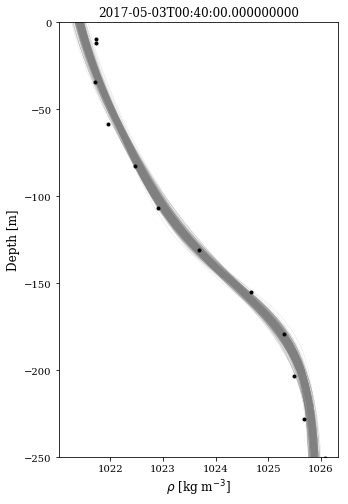

In [19]:
plt.figure(figsize=(5,8))
tstep = -15
samples = 400
for rand_loc in np.random.randint(0, ntrace, samples):
    rhotmp = double_tanh(data[:,tstep, rand_loc], zout)
    plt.plot(rhotmp, zout, '0.5', lw=0.2, alpha=0.5)
    
plt.plot(rho[tstep,:],rho.depth[:], 'k.')
#plt.plot(rhomean*RHO0, zout, 'k--',) # Mean fit

plt.ylim(zmin,0 )
plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho$ [kg m$^{-3}$]')
plt.title(rho.time.values[tstep])

In [8]:
from iwaves import kdv
from iwaves.utils import isw

In [9]:
%%time
from tqdm import tqdm # progress bar

samples = 200
alpha_ens = np.zeros((nt,samples))
c_ens = np.zeros((nt,samples))

rand_loc = np.random.randint(0, ntrace, samples)

for tstep in tqdm(range(0,nt)):
    #if (tstep%20==0):
    #    print('%d of %d...'%(tstep,nt))
    for ii in range(samples):
        rhotmp = double_tanh(data[:,tstep, rand_loc[ii]], zout)

        N2 = -9.81/1000*np.gradient(rhotmp,dz)

        phi,cn = isw.iwave_modes(N2, dz)
        
        phi_1 = phi[:,mode]
        phi_1 =phi_1 / np.abs(phi_1).max()
        phi_1 *= np.sign(phi_1.sum())
        
        alpha = isw.calc_alpha(phi_1, cn[mode],N2,dz)

        alpha_ens[tstep,ii] = alpha
        c_ens[tstep,ii] = cn[mode]
        #mykdv = kdv.KdV(rhotmp,zout)


100%|██████████| 1481/1481 [13:46<00:00,  1.79it/s]

CPU times: user 47min 27s, sys: 3min 23s, total: 50min 50s
Wall time: 13min 46s


In [10]:
omega = 2*np.pi/(12.42*3600)
a0 = 25.

Ls = c_ens**2. / (np.abs(alpha_ens)*a0*omega) / 1000.
Ls_median = np.median(c_ens,axis=1)**2. / (np.abs(np.median(alpha_ens,axis=1))*a0*omega) / 1000.

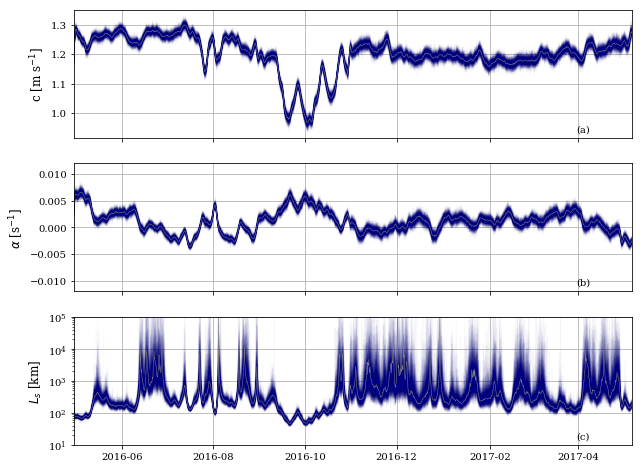

In [11]:
#time = range(0,nt)
time = rho.time.values

plt.figure(figsize=(10,8))
ax1 = plt.subplot(311, rasterized=False)
ax2 = plt.subplot(312, rasterized=False)
ax3 = plt.subplot(313, yscale='log', rasterized=False)

#ax1.set_ylim(0.75,1.35)
ax2.set_ylim(-0.012,0.012)
ax3.set_ylim(1e1,1e5)
ax1.set_ylabel('c [m s$^{-1}$]')
ax2.set_ylabel(r'$\alpha$ [s$^{-1}$]')
ax3.set_ylabel(r'$L_s$ [km]')

ax1.grid(b=True)
ax2.grid(b=True)
ax3.grid(b=True)

ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax1.set_xlim([time[0],time[-1]])
ax2.set_xlim([time[0],time[-1]])
ax3.set_xlim([time[0],time[-1]])

ax1.text(0.9,0.05,'(a)', transform=ax1.transAxes)
ax2.text(0.9,0.05,'(b)', transform=ax2.transAxes)
ax3.text(0.9,0.05,'(c)', transform=ax3.transAxes)

c_lines = np.zeros((samples,nt,2))
for ii in range(samples):
    #c_lines[ii,:,0]  = range(nt)
    #c_lines[ii,:,1]  = c_ens[:,ii]
    p1, = ax1.plot(time,c_ens[:,ii],'navy', lw=1, alpha=0.02)
    p1.set_rasterized(True)
    
    p1, = ax2.plot(time,alpha_ens[:,ii],'navy', lw=1, alpha=0.02)
    p1.set_rasterized(True)

    p1, = ax3.plot(time,Ls[:,ii],'navy', lw=1, alpha=0.02)
    p1.set_rasterized(True)

#l1 = LineCollection(c_lines)
#ax1.add_collection(l1)
ax1.plot(time, np.median(c_ens,axis=1),'0.5',lw=0.5)
ax2.plot(time, np.median(alpha_ens,axis=1),'0.5',lw=0.5)
ax3.plot(time, Ls_median,'0.5',lw=0.5)

plt.savefig('FIGURES/c_alpha_Ls_uncert_%s.pdf'%sitename, dpi=150)
plt.savefig('FIGURES/c_alpha_Ls_uncert_%s.png'%sitename, dpi=150)

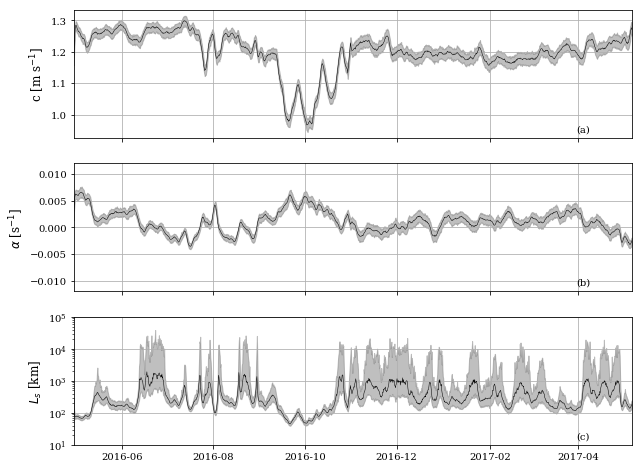

In [12]:
#time = range(0,nt)
time = rho.time.values

plt.figure(figsize=(10,8))
ax1 = plt.subplot(311, rasterized=False)
ax2 = plt.subplot(312, rasterized=False)
ax3 = plt.subplot(313, yscale='log', rasterized=False)

#ax1.set_ylim(0.75,1.35)
ax2.set_ylim(-0.012,0.012)
ax3.set_ylim(1e1,1e5)
ax1.set_ylabel('c [m s$^{-1}$]')
ax2.set_ylabel(r'$\alpha$ [s$^{-1}$]')
ax3.set_ylabel(r'$L_s$ [km]')

ax1.grid(b=True)
ax2.grid(b=True)
ax3.grid(b=True)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_yticks([10,1e2,1e3,1e4,1e5])

ax1.set_xlim([time[0],time[-1]])
ax2.set_xlim([time[0],time[-1]])
ax3.set_xlim([time[0],time[-1]])

ax1.text(0.9,0.05,'(a)', transform=ax1.transAxes)
ax2.text(0.9,0.05,'(b)', transform=ax2.transAxes)
ax3.text(0.9,0.05,'(c)', transform=ax3.transAxes)

ax1.plot(time, np.median(c_ens,axis=1),'k',lw=0.5)
ax2.plot(time, np.median(alpha_ens,axis=1),'k',lw=0.5)
ax3.plot(time, np.percentile(Ls,50, axis=1,),'k',lw=0.5)
#ax3.plot(time, Ls_median,'k',lw=0.5)

ax1.fill_between(time,np.percentile(c_ens,5, axis=1),np.percentile(c_ens,95, axis=1),\
        color='0.5', alpha=0.5)

ax2.fill_between(time,np.percentile(alpha_ens,5, axis=1),np.percentile(alpha_ens,95, axis=1),\
        color='0.5', alpha=0.5)

ax3.fill_between(time,np.percentile(Ls,5, axis=1),np.percentile(Ls,95, axis=1),\
        color='0.5', alpha=0.5)


plt.savefig('FIGURES/c_alpha_Ls_uncert_95c_%s.pdf'%sitename, dpi=150)
plt.savefig('FIGURES/c_alpha_Ls_uncert_95c_%s.png'%sitename, dpi=150)

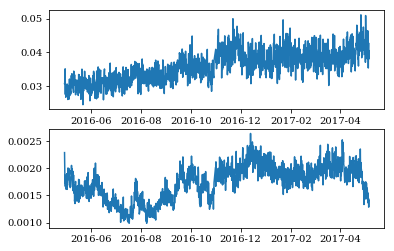

In [13]:
c_diff = np.percentile(c_ens,95, axis=1) - np.percentile(c_ens,5, axis=1)
alpha_diff = np.percentile(alpha_ens,95, axis=1) - np.percentile(alpha_ens,5, axis=1)

plt.figure()
plt.subplot(211)
plt.plot(time, c_diff)

plt.subplot(212)
plt.plot(time, alpha_diff)